In [34]:
# Taken from https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer

from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')



# The PLEX Crash

## Background

Previous notes [here](http://nbviewer.jupyter.org/github/eigenframe/EVE/blob/master/ipython/QC%20I.ipynb).

In [5]:
from IPython.display import *
import numpy as np
import seaborn as sns
from pandas import * 
import pycrest
%matplotlib inline 


In [6]:
def crest_quote(name, eve = None, side = None, volume = 1, prices_only = True, region_id = 10000002):
    # Modified from https://github.com/flesser/django-crest-example under MIT License
    global type_id_dict
    eve =  pycrest.EVE() if eve is None else eve
    
    
    endpoint = eve._public_endpoint
    type_id = type_id_dict[name]        
    type_url = "{0}types/{1}/".format(endpoint, type_id)
    bids_url = "{0}market/{1}/orders/buy/?type={2}".format(endpoint, region_id, type_url)
    asks_url = "{0}market/{1}/orders/sell/?type={2}".format(endpoint, region_id, type_url)

    asks = eve.get(asks_url)['items']
    bids = eve.get(bids_url)['items']

    asks = sorted(asks, key=lambda k: k['price'])
    bids = sorted(bids, key=lambda k: k['price'], reverse=True)



    book = {'asks': asks, 'bids': bids}
    
    bidL2 = 1
    while sum([b['volume'] for b in book['bids'][:bidL2]]) < volume:
        bidL2 += 1
        if bidL2 >= len(book['bids']):
            bidL2 = 0
            break
    
    askL2 = 1
    while sum([a['volume'] for a in book['asks'][:askL2]]) < volume:
        askL2 += 1
        if askL2 >= len(book['asks']):
            askL2 = 0
            break
    bid_quote = book['bids'][:bidL2] if bidL2 > 0 else [{'price': np.nan}]
    ask_quote = book['asks'][:askL2] if askL2 > 0 else [{'price': np.nan}]
    
    return {'volume':volume,'bid': bid_quote[-1], 'ask':ask_quote[-1]} if not prices_only else {'volume':volume,'bid': bid_quote[-1]['price'],'ask': ask_quote[-1]['price']}


def history(name = None, type_id = None, days = 100, region_id = 10000002):
    global type_id_dict
    if name is None and type_id is None:
        return None
    elif type_id is None:
        type_id = type_id_dict[name]
    
    history = eve.get('https://public-crest.eveonline.com/market/{}/types/{}/history/'.format(region_id, type_id))
    out = history['items']
    while 'next' in history.keys():
        history = eve.get('https://public-crest.eveonline.com/market/{}/types/{}/history/'.format(region_id, type_id))
        out.extend(history['items'])
    out = DataFrame(out)
    return out.set_index(DatetimeIndex(out['date'])).drop('date',axis=1).iloc[-days:]
    


In [7]:
eve = pycrest.EVE()
type_id_dict = {'PLEX':29668,'Skill Injector':40520,'Skill Extractor':40519}
sns.set_palette(sns.color_palette("Set2"))


In [8]:
# import time
# import urllib2
# tid = 21
# tic = time.time()

# (history(type_id=tid))
# print time.time()-tic
# tic = time.time()

# resp = urllib2.urlopen('https://crest-tq.eveonline.com/market/10000002/types/{}/history/'.format(tid))
# r = resp.read()
# # eve.get('https://public-crest.eveonline.com/market/10000002/types/{}/history/'.format(tid))

# print time.time()-tic

# tic = time.time()

# # crest_quote()

## Empirical Results


In [15]:
region_id = 10000002
# Constants

plex_aur = 3500.
extractor_aur = 1000.
c = extractor_aur / plex_aur
sns.plt.rcParams['figure.figsize'] = (15.0, 7.0);
hist_plex = history(name='PLEX', days = 365)
hist_inj = history(name='Skill Injector', days = 100)
hist_ext = history(name='Skill Extractor', days = 100)



In [16]:
e = hist_ext['avgPrice']
p = hist_plex['avgPrice'][e.index]
y = 1 / c * np.divide(e,p) - 1
i = hist_inj['avgPrice']

Looking closely at PLEX prices since skill trading inception:

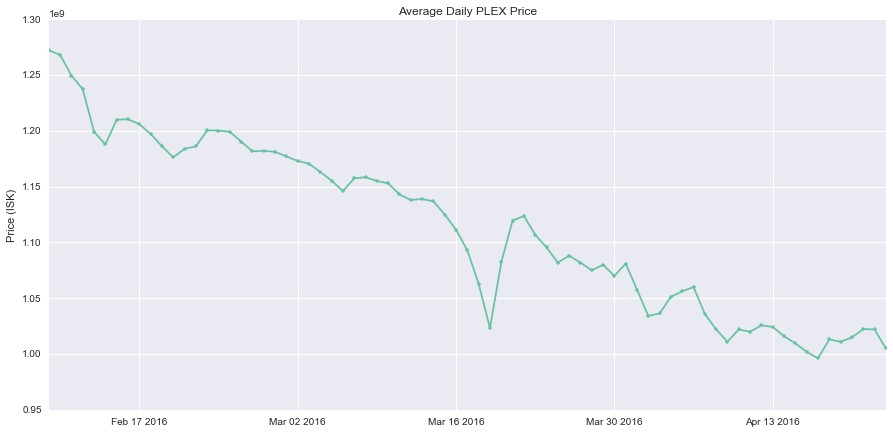

In [22]:
sns.plt.plot(hist_plex['avgPrice'][i.index],'.-');
sns.plt.ylabel('Price (ISK)')
sns.plt.title('Average Daily PLEX Price')

Almost exactly 1 month after the parabolic collapse (and subsequent correction) of PLEX prices, the market has continued its decline to a new local minimum. Whichever force was responsible for the rapid recovery (or intervention) in mid-March is either absent, unable, or unmotivated to achieve the same result now. 

In [ ]:
sns.plt.plot(y,'o-');
sns.plt.plot(hist_plex['avgPrice'].shift(-30) / hist_plex['avgPrice'] - 1,'o-');
sns.plt.plot(e.shift(-30) / e - 1,'o-');
sns.plt.plot(i.shift(-30) / i - 1,'o-');

sns.plt.plot(0*hist_plex['avgPrice'],'o-');
sns.plt.legend(['Risk Neutral (Model Implied)','PLEX (Realized)','Extractor (Realized)','Injector (Realized)','ISK Wallet']);
sns.plt.title('30-Day Return (Based on Daily Average Prices)');
sns.plt.ylabel('Return');

Looking more closely at the returns since the inception of skill trading:

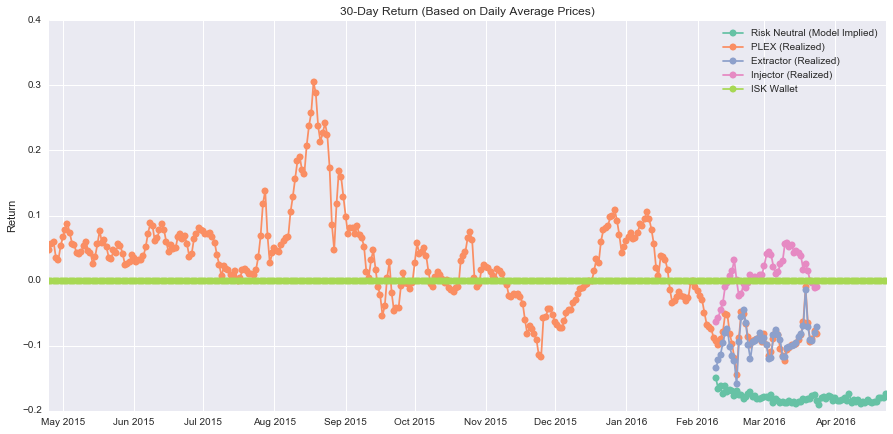

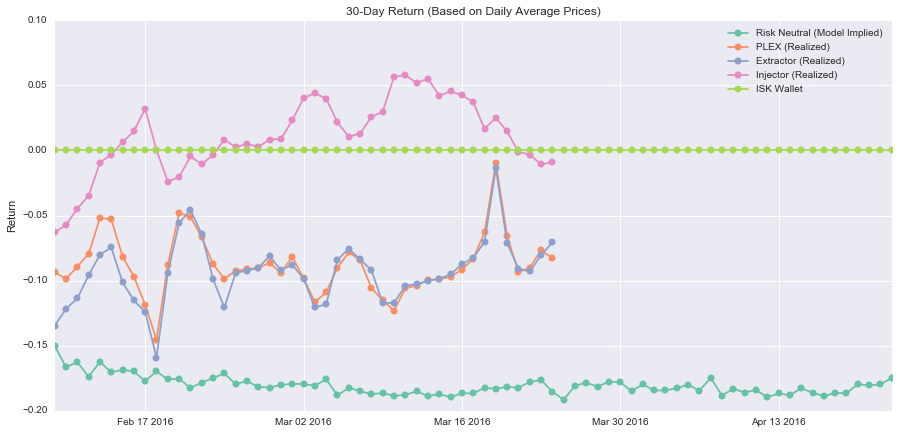

In [18]:
sns.plt.plot(y,'o-');

sns.plt.plot(p.shift(-30) / p - 1,'o-');

sns.plt.plot(e.shift(-30) / e - 1,'o-');
sns.plt.plot(i.shift(-30) / i - 1,'o-');

sns.plt.plot(0*p,'o-');
sns.plt.legend(['Risk Neutral (Model Implied)','PLEX (Realized)','Extractor (Realized)','Injector (Realized)','ISK Wallet']);
sns.plt.title('30-Day Return (Based on Daily Average Prices)');
sns.plt.ylabel('Return');
sns.plt.figure()

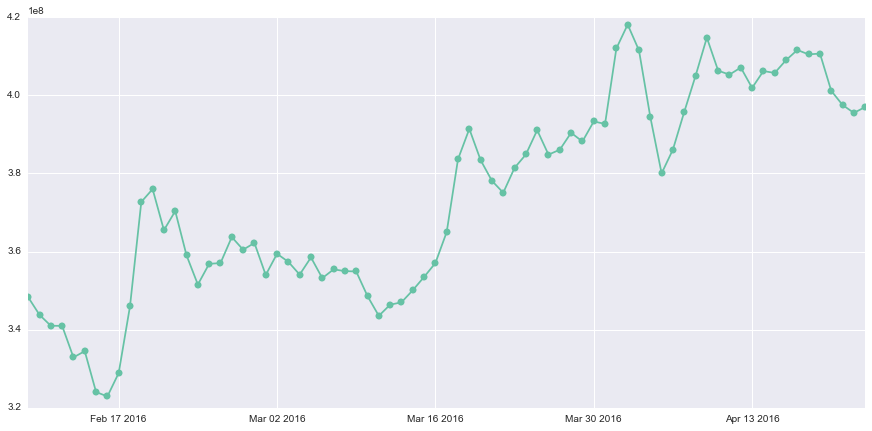

In [19]:
sns.plt.plot(i-e,'o-')

Despite the mid-March crash/recovery in PLEX prices, the realized 30-Day PLEX return has been strictly negative since the inception of skill trading. Despite coming close to breaking even in the last 2 weeks, the market has continually fallen short of matching the return on wallet ISK (0%). This means that since skill trading inception, **the only way to return a profit on a PLEX investment has been to exercise it and produce skill injectors.** 

It remains an open question whether the PLEX risk premium -- the gap between the Realized (orange) and Risk Neutral (green) lines in the chart above -- will really collapse closer to 0. In reality, there is probably enough intrinsic value in PLEX to maintain the positive risk premium. One thing does appear certain, regardless: **holding ISK is now a better investment than holding PLEX**. As of a few days ago, a skill injctor has produced a worse 30-Day return than simply holding ISK for the same amount of time. Assuming that spurring price inflation (and reducing ISK hoarding) is CCP's primary motivation for the inception of skill trading, this is a **disastrous** result.




From the March 2016 Monthly Economic Report [LINK](https://community.eveonline.com/news/dev-blogs/monthly-economic-report-march-2016/):

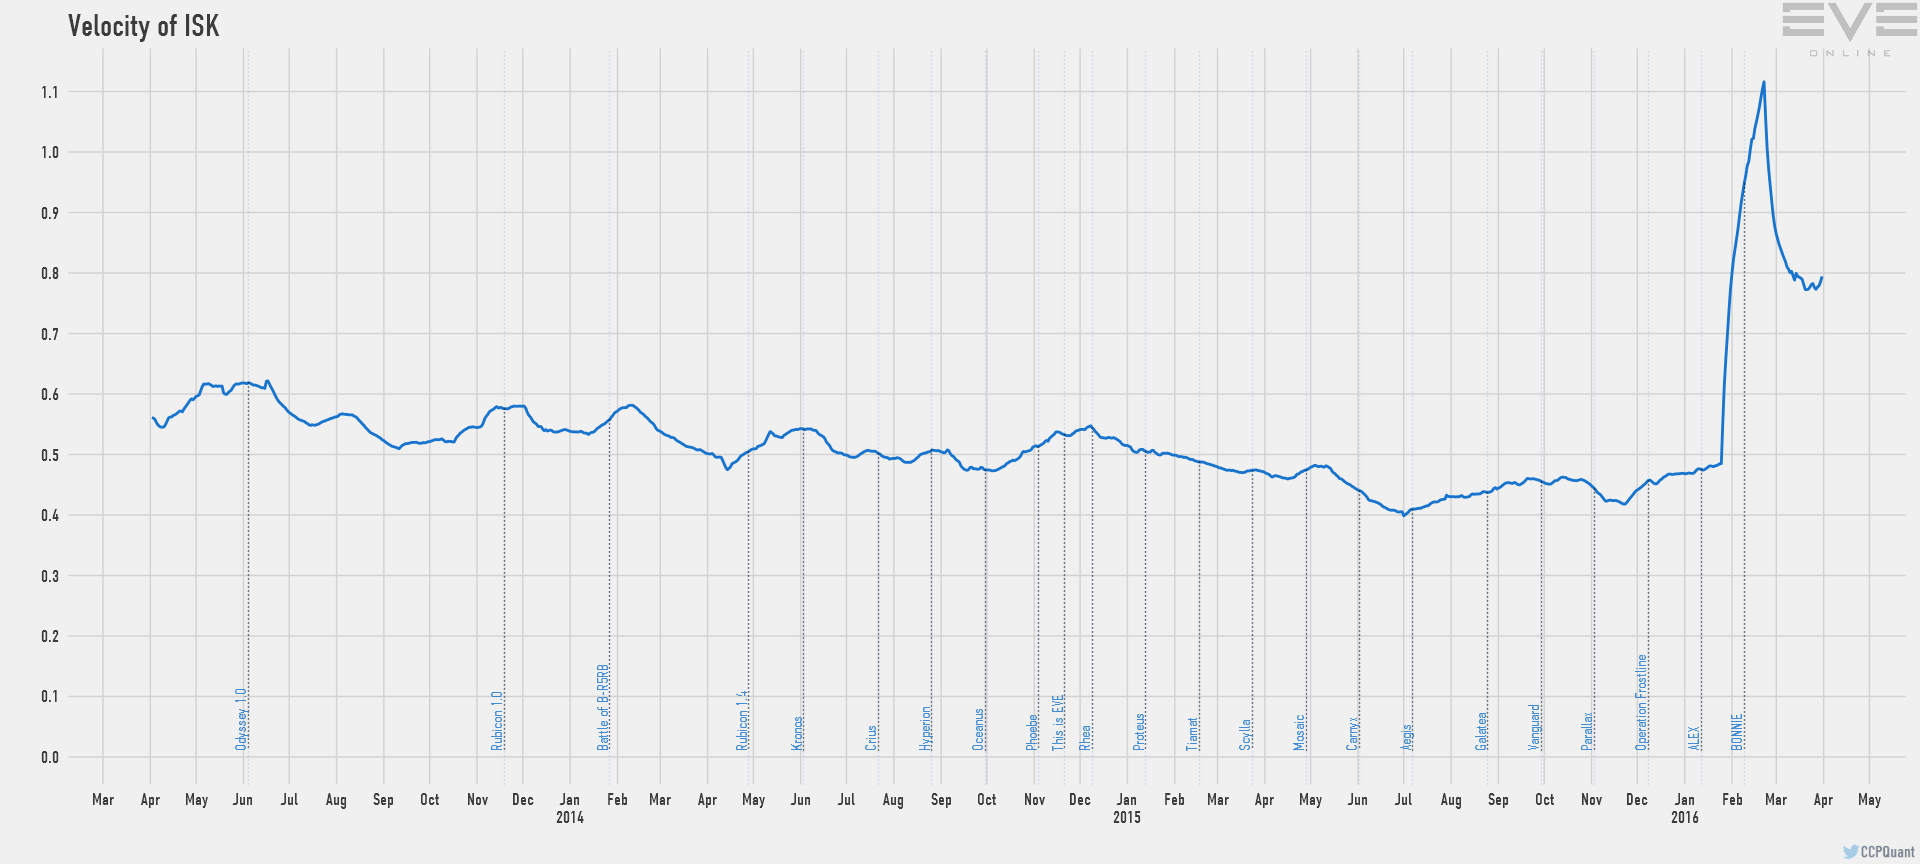

In [148]:
Image('http://content.eveonline.com/www/newssystem/media/70162/1/9c_velocity.png')

While it is tempting to draw conclusions about a new regime of ISK velocity stability, only time will tell if this value really has been sustainably elevated by a significant degree. Regardless, CCP is cautioned against focusing too closely on this (or any) single value as a measure of success. If holding ISK (@ 0%) yields a better return than holding PLEX does, this newfound velocity will inevitably decay.

Finally, we may revisit the PLEX premium on extractors (the amount saved by buying extractors with ISK vs. converting PLEX to AUR):

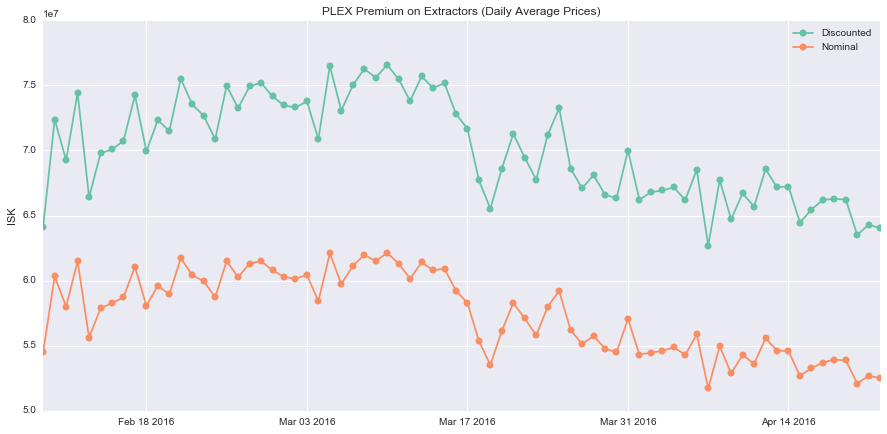

In [14]:
sns.plt.plot(1 / (y + 1) * (c * hist_plex['avgPrice'].loc[hist_ext.index] - hist_ext['avgPrice']),'o-');
sns.plt.plot(c * hist_plex['avgPrice'].loc[hist_ext.index] - hist_ext['avgPrice'],'o-');

sns.plt.legend(['Discounted','Nominal']);
sns.plt.ylabel('ISK');
sns.plt.title('PLEX Premium on Extractors (Daily Average Prices)');

Regardless of whether we apply a discount or not, the premium is currently tracking the overall PLEX trend (down). This may lend credence to the theory that PLEX really has been overpriced since the inception of skill trading; if this relationship truly is financially significant, there are a number of trading strategies that emerge as a direct result.

## Impact


It would seem to be the case that since the traders with the most skill points to extract and market as injectors were also the traders with the most ISK in their wallets (an asssumption in line with the deflationary trend of the market over the last few years). If this is the case, then the future of the skill trading economy depends on CCP's ability to stiumulate new skill point demand amongst the pilots and corporations with the most ISK in their wallets. However, as was noted in the previous note, the first attempt to institute a change like this (the Force Auxilliary skill tree) was abandoned after immediately being met by player backlash.


At this point, the lack of a PLEX credit market (and thus, the lack of reliable PLEX short-sale mechanism) appears to be the only thing keeping the problem from getting worse. 


CCP's 2015 financial statements [LINK](http://marketsforisk.blogspot.com/2016/04/ccp-financial-statements-for-2015-review.html) describe the refinancing of a convertible bond (\$20 million @ 7%) into a bank loan (\$24 million @ LIBOR +4.7%). In addition, PLEX outstanding are described on the balance sheet as $>$\$3 million of Deferred Income. [LINK](http://marketsforisk.blogspot.co.uk/2014/09/a-new-angle-on-plex-perhaps.html) When these PLEX are exercised (for example, to produce skill injectors), CCP can book the original PLEX purchase as current revenue. 

These are both important points because together they give us an idea of the impact of skill trading on CCP's financial future. 

CCP's credit is priced under an assumption of Deferred Income becoming current at a certain rate. This is intuitively connected to PLEX's basic function as a debt security [LINK](http://www.polygon.com/2014/5/5/5677734/bitcoin-plex-isk-eve-online); as debt gets cheaper, interest rates rise. Although PLEX is not sold or regulated as a real security, a creditor may use the demand for PLEX as a proxy for CCP credit. The perception that EVE players are not willing to hold PLEX as an investment is dangerous for CCP's future financing efforts (not to mention the operational impact of reduced revenue, even in a currently cash-rich environment).






CCP's apparent excitement [LINK](http://updates.eveonline.com/conflict/world-war-bee-the-battle-of-m-oee8/) over the massive in-game war that has developed over the preceding weeks is presumably (and understandably) motivated by the opportunity to increase their subscription base (and correspondingly, the PLEX price). However, in the absense of subscription growth, the war presents a bigger danger in the form of a higher liquidity preference for ISK because, quite simply, wars cost money and there is no reliable ISK credit market (this is one reason why it is dangerous to rely only on ISK velocity as a measure of skill trading's impact). 

Relatedly, while a weaker price does incentivize exercising PLEX (and thus may initially appear revenue-positive for CCP), the volume of this exercise must be overwhelming to have any impact on price stability. Quantifying this relationship is a dynamic programming problem that will hopefully be covered in a forthcoming note.


Finally, at the time of writing, we are only a few days away from the Citadel expansion. This release brings with it some major changes to the ingame market structure; the economic impact of this (not just on demand, but on liquidity as well) will be something to watch closely.

***
## About the Author

The author is a derivatives strategist with a shaky and incomplete macroeconomics education. Corrections, questions, and inquiries should be directed to $\text{eigenframe} {[AT}]$ gmail$.$com

d4980306875e439c72bbc3fa6e195bc6c03f39f61679b3dce4f9bee4420e37c4

## About this Document

The Document has been prepared solely for informational purposes, and is not an offer to buy or sell or a solicitation of an offer to buy or sell any security, product, service or investment. The opinions expressed in this Site do not constitute investment advice and independent advice should be sought where appropriate. The information provided on this site or in any communication containing a link to this site is not intended for distribution to, or use by, any person or entity in any jurisdiction or country where such distribution or use would be contrary to law or regulation or which would subject the author or its affiliates to any registration requirement within such jurisdiction or country. Neither the information, nor any opinion contained in this document constitutes a solicitation or offer by the offer or its affiliates to buy or sell any securities, futures, options or other financial instruments or provide any investment advice or service.


EVE Online/DUST514, the EVE/DUST514 logo, EVE/DUST514 and all associated logos and designs are the intellectual property of CCP hf. All artwork, screenshots, characters, vehicles, storylines, world facts or other recognizable features of the intellectual property relating to these trademarks are likewise the intellectual property of CCP hf. EVE Online and the EVE logo are the registered trademarks of CCP hf. All rights are reserved worldwide. All other trademarks are the property of their respective owners. CCP is in no way responsible for the content of this document, nor can it be liable for any damage arising from the use of this document.



Graphics via seaborn and matplotlib, CREST API via pycrest.


django-crest-example (Copyright (c) 2015 Florian Eßer) modified under The MIT License (MIT), reproduced below

>The MIT License (MIT)
>
>Copyright (c) 2015 Florian Eßer
>
>Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:
>
>The above copyright notice and this permission notice shall be included in all
>copies or substantial portions of the Software.
>
>THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE X CONSORTIUM BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.